**This Code has not been made by me but I have studied it thoroughly**

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import random
import math
import time
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import torch

In [3]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
csse_daily_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/08-16-2020.csv')


In [4]:
confirmed_df
# confirmed_df has time series data of cases over time

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,48718,48952,49161,49378,49621,49681,49817,50013,50190,50433,50655,50810,50886,51039,51280,51350,51405,51526,51526,51526,51526,53011,53105,53105,53207,53332,53400,53489,53538,53584,53584,53775,53831,53938,53984,54062,54141,54278,54403,54483
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,49191,50000,50637,51424,52004,52542,53003,53425,53814,54317,54827,55380,55755,56254,56572,57146,57727,58316,58316,58991,59438,59623,60283,61008,61705,62378,63033,63595,63971,64627,65334,65994,66635,67216,67690,67982,68568,69238,69916,70655
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,92597,93065,93507,93933,94371,94781,95203,95659,96069,96549,97007,97441,97857,98249,98631,98988,99311,99610,99897,100159,100408,100645,100873,101120,101382,101657,101913,102144,102369,102641,102860,103127,103381,103611,103833,104092,104341,104606,104852,105124
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7382,7382,7446,7466,7519,7560,7577,7602,7633,7669,7699,7756,7806,7821,7875,7919,7983,8049,8117,8166,8192,8249,8308,8348,8348,8489,8586,8586,8586,8682,8818,8868,8946,9038,9083,9083,9194,9308,9379,9416
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,16277,16362,16407,16484,16562,16626,16644,16686,16802,16931,17029,17099,17149,17240,17296,17371,17433,17553,17568,17608,17642,17684,17756,17864,17974,18066,18156,18193,18254,18343,18425,18613,18679,18765,18875,18926,19011,19093,19177,19269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,2,2,2,2,6,6,8,8,8,10,10,13,13,14,15,15,16,16,16,16,16,16,16,16,16,16,16,16,16,16,...,1402,1405,1405,1407,1410,1411,1413,1414,1420,1421,1432,1439,1440,1441,1451,1454,1456,1465,1474,1482,1494,1497,1504,1505,1509,1512,1513,1514,1515,1520,1521,1531,1536,1537,1537,1539,1540,1544,1546,1548
269,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,111102,113409,115606,117755,119612,121216,122643,123945,125506,127376,129080,130598,131904,133093,134310,135459,136736,138004,139223,140287,141219,142228,143169,144257,145252,146074,146701,147400,148171,148968,149769,150505,151142,151569,152031,152555,153093,153590,154063,154557
270,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2084,2085,2085,2087,2087,2087,2087,2087,2087,2087,2092,2092,2092,2094,2096,2096,2097,2099,2101,2101,2101,2101,2101,2102,2104,2104,2104,2104,2105,2107,2109,2110,2111,2112,2112,2113,2115,2115,2115,2118
271,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,18322,18428,18456,18504,18575,18620,18716,18768,18881,19122,19234,19571,19671,19834,19943,20177,20462,20725,20997,21230,21582,21

In [5]:
csse_daily_df

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2020-08-17 04:27:20,33.939110,67.709953,37590,1376,27166,9055.0,Afghanistan,96.577452,3.657304
1,NaN,NaN,NaN,Albania,2020-08-17 04:27:20,41.153300,20.168300,7380,228,3794,3358.0,Albania,256.445896,3.089431
2,NaN,NaN,NaN,Algeria,2020-08-17 04:27:20,28.033900,1.659600,38583,1370,27017,10196.0,Algeria,87.986505,3.550787
3,NaN,NaN,NaN,Andorra,2020-08-17 04:27:20,42.506300,1.521800,989,53,863,73.0,Andorra,1280.010354,5.358948
4,NaN,NaN,NaN,Angola,2020-08-17 04:27:20,-11.202700,17.873900,1906,88,628,1190.0,Angola,5.799259,4.616999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3941,NaN,NaN,NaN,Vietnam,2020-08-17 04:27:20,14.058324,108.277199,964,24,456,484.0,Vietnam,0.990358,2.489627
3942,NaN,NaN,NaN,West Bank and Gaza,2020-08-17 04:27:20,31.952200,35.233200,16534,110,9838,6586.0,West Bank and Gaza,324.106091,0.665296
3943,NaN,NaN,NaN,Yemen,2020-08-17 04:27:20,15.552727,48.516388,1869,530,1013,326.0,Yemen,6.266352,28.357410
3944,NaN,NaN,NaN,Zambia,2020-08-17 04:27:20,-13.133897,27.849332,9343,260,8412,671.0,Zambia,50.821488,2.782832


In [6]:
csse_daily_df['Country_Region'].value_counts()

US              3261
Russia            83
Japan             49
India             37
Colombia          33
                ... 
Zimbabwe           1
Portugal           1
Bahrain            1
Eritrea            1
Saudi Arabia       1
Name: Country_Region, Length: 188, dtype: int64

In [8]:

%pip install geopandas

     |████████████████████████████████| 972kB 5.5MB/s 
     |████████████████████████████████| 14.8MB 301kB/s 
     |████████████████████████████████| 6.5MB 55.8MB/s 


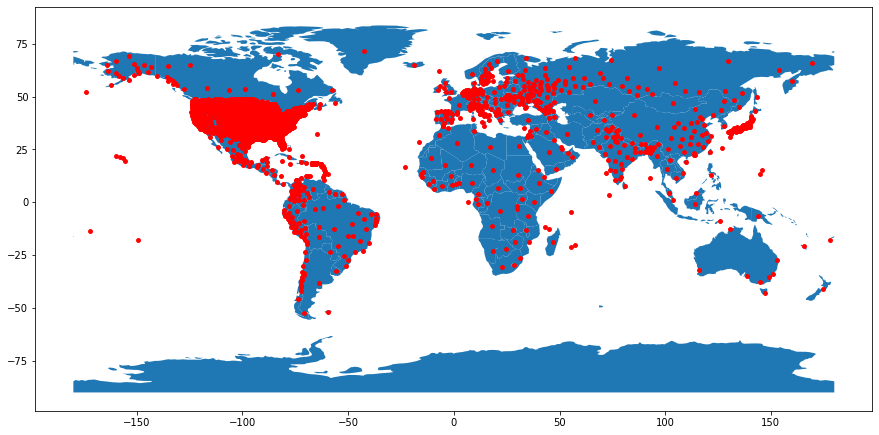

In [9]:

import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(csse_daily_df['Long_'], csse_daily_df['Lat'])]
gdf = GeoDataFrame(csse_daily_df[['Lat','Long_']], geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(15, 10)), marker='o', color='red', markersize=15);

In [10]:
csse_daily_df['Country_Region'].value_counts()[:7]
# US has over 3000 entries in data

US          3261
Russia        83
Japan         49
India         37
Colombia      33
China         33
Mexico        32
Name: Country_Region, dtype: int64

In [11]:
top_c = csse_daily_df.groupby(['Country_Region']).Confirmed.sum().sort_values(ascending=False)
top_c

Country_Region
US                       5410880
Brazil                   3340197
India                    2647663
Russia                    920719
South Africa              587345
                          ...   
Dominica                      18
Saint Kitts and Nevis         17
Holy See                      12
MS Zaandam                     9
Samoa                          0
Name: Confirmed, Length: 188, dtype: int64

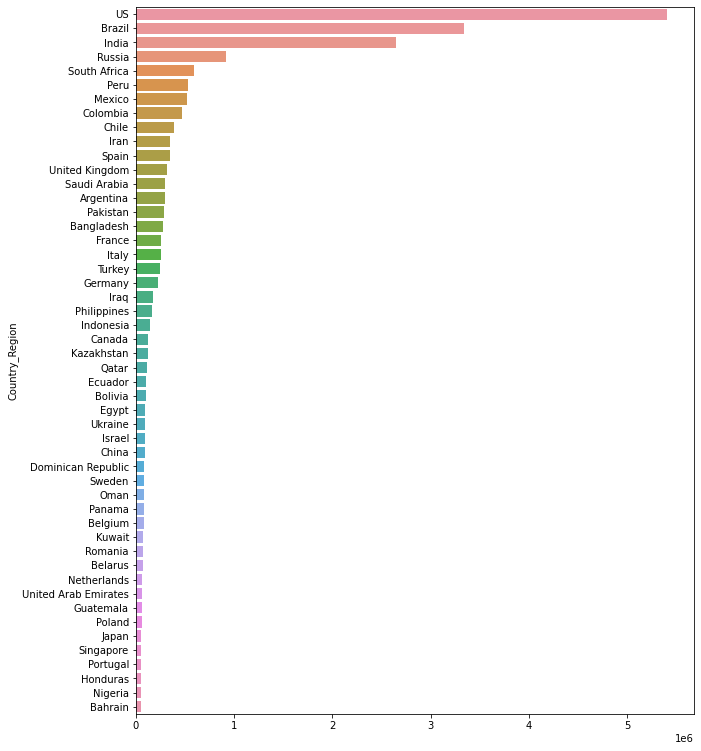

In [12]:

# Top 50 Country wise Confirmed cases acc to given data

fig, ax = plt.subplots(figsize=(10, 13))
sns.barplot(y=top_c.index[:50], x=top_c.values[:50])

**So, let's focus on US only and see what columns have significance in the result or what are the correlations, to see whether we should do time series prediction only or should also look at other variables to consider.**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


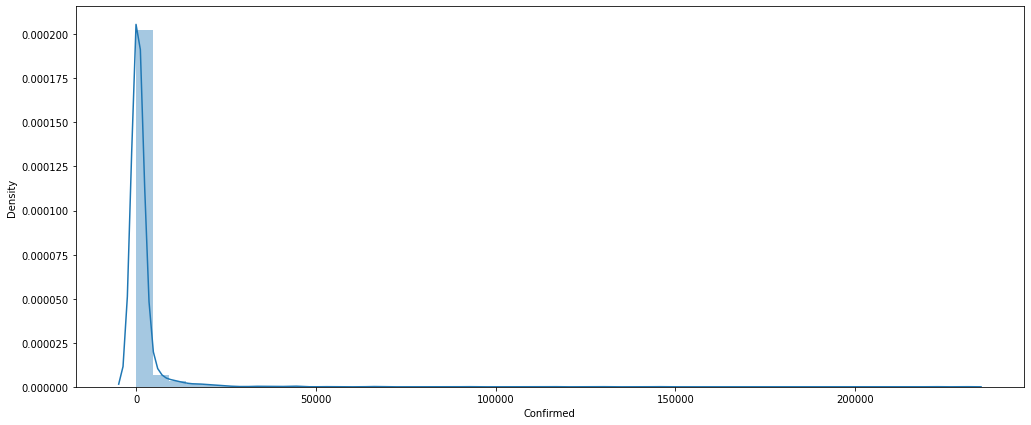

In [13]:
csse_daily_df_us = csse_daily_df[csse_daily_df['Country_Region']=='US'] # get US only data

fig, ax = plt.subplots(figsize=(17, 7))
sns.distplot(csse_daily_df_us['Confirmed'].dropna())

In [14]:
# Drop Unnecessary Columns
csse_daily_df_us.drop(['Country_Region','Province_State','Long_','Last_Update','Combined_Key'], axis=1, inplace=True)

csse_daily_df_us.Recovered.value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0          3260
1833067       1
Name: Recovered, dtype: int64

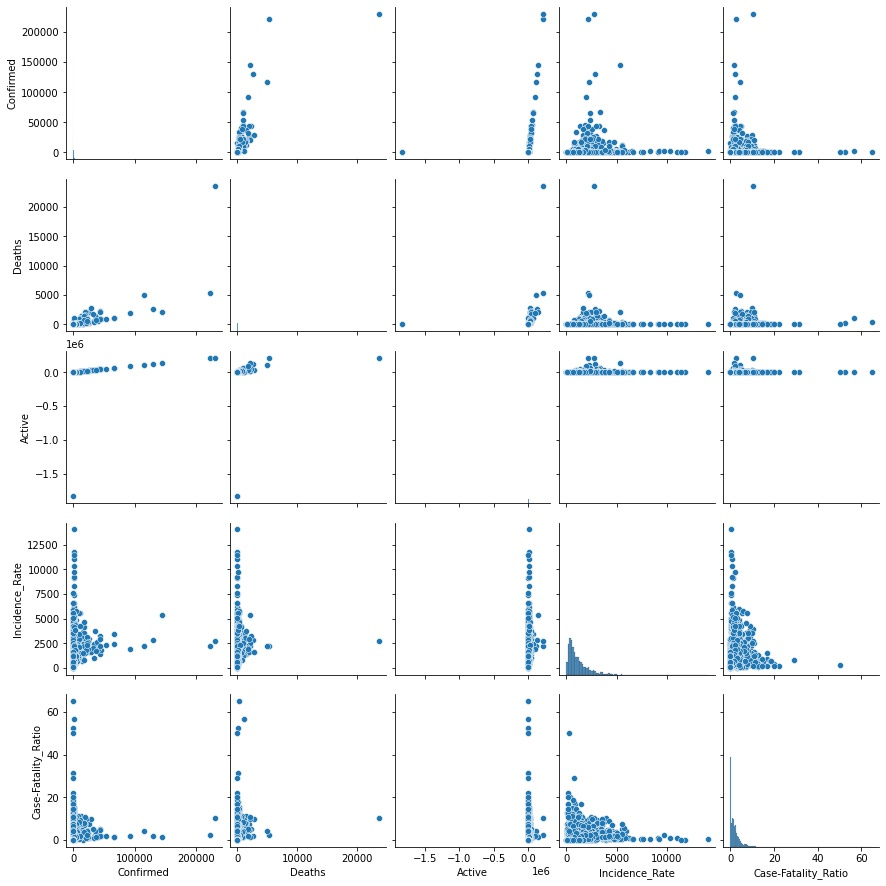

In [15]:
sns.pairplot(csse_daily_df_us[['Confirmed','Deaths','Active','Incidence_Rate','Case-Fatality_Ratio']])

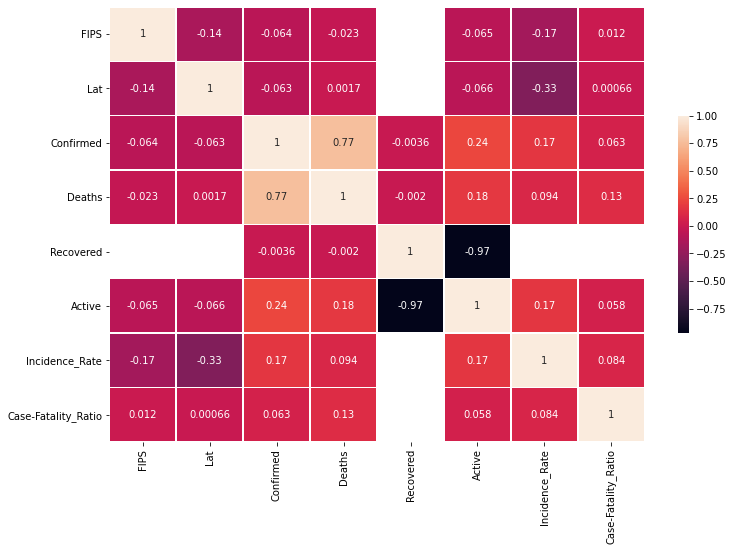

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
corr = csse_daily_df_us.corr()
sns.heatmap(corr, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

**Confirm, death, and Active have high positive corelation, where as rest has negative corelation**

In [17]:
# get a list of dates 
dates = confirmed_df.keys()[4:]

confirmed = confirmed_df.loc[:, dates]
deaths = deaths_df.loc[:, dates]
recoveries = recoveries_df.loc[:, dates]

confirmed

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,...,48718,48952,49161,49378,49621,49681,49817,50013,50190,50433,50655,50810,50886,51039,51280,51350,51405,51526,51526,51526,51526,53011,53105,53105,53207,53332,53400,53489,53538,53584,53584,53775,53831,53938,53984,54062,54141,54278,54403,54483
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,49191,50000,50637,51424,52004,52542,53003,53425,53814,54317,54827,55380,55755,56254,56572,57146,57727,58316,58316,58991,59438,59623,60283,61008,61705,62378,63033,63595,63971,64627,65334,65994,66635,67216,67690,67982,68568,69238,69916,70655
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,92597,93065,93507,93933,94371,94781,95203,95659,96069,96549,97007,97441,97857,98249,98631,98988,99311,99610,99897,100159,100408,100645,100873,101120,101382,101657,101913,102144,102369,102641,102860,103127,103381,103611,103833,104092,104341,104606,104852,105124
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7382,7382,7446,7466,7519,7560,7577,7602,7633,7669,7699,7756,7806,7821,7875,7919,7983,8049,8117,8166,8192,8249,8308,8348,8348,8489,8586,8586,8586,8682,8818,8868,8946,9038,9083,9083,9194,9308,9379,9416
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,16277,16362,16407,16484,16562,16626,16644,16686,16802,16931,17029,17099,17149,17240,17296,17371,17433,17553,17568,17608,17642,17684,17756,17864,17974,18066,18156,18193,18254,18343,18425,18613,18679,18765,18875,18926,19011,19093,19177,19269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,0,2,2,2,2,2,2,2,2,2,6,6,8,8,8,10,10,13,13,14,15,15,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,...,1402,1405,1405,1407,1410,1411,1413,1414,1420,1421,1432,1439,1440,1441,1451,1454,1456,1465,1474,1482,1494,1497,1504,1505,1509,1512,1513,1514,1515,1520,1521,1531,1536,1537,1537,1539,1540,1544,1546,1548
269,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,111102,113409,115606,117755,119612,121216,122643,123945,125506,127376,129080,130598,131904,133093,134310,135459,136736,138004,139223,140287,141219,142228,143169,144257,145252,146074,146701,147400,148171,148968,149769,150505,151142,151569,152031,152555,153093,153590,154063,154557
270,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2084,2085,2085,2087,2087,2087,2087,2087,2087,2087,2092,2092,2092,2094,2096,2096,2097,2099,2101,2101,2101,2101,2101,2102,2104,2104,2104,2104,2105,2107,2109,2110,2111,2112,2112,2113,2115,2115,2115,2118
271,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,18322,18428,18456,18504,18575,18620,18716,18768,18881,19122,19234,19571,19671,19834,19943,20177,20462,20725,20997,21230,21582,21993,22645,23495,24297,25326,26567,27728,28596,29757,31100,32800,34278,36074,37605,38207,39515,40949,42213,43333


In [18]:

total_cases = confirmed.sum(axis=0).values
total_deaths = deaths.sum(axis=0).values
total_recoveries = recoveries.sum(axis=0).values

# let's find how many are active still, those who didn't die or recovered but were daignozed
total_active = total_cases - total_deaths - total_recoveries

In [19]:

print("total cases accumulated = {} \noverall total_cases = {}".format(max(total_cases),max(confirmed['7/13/20'])))

total cases accumulated = 98177108 
overall total_cases = 3361729


In [20]:
# get the unique countries
countries = confirmed_df['Country/Region'].unique()
len(countries)

192

**Worst affected counutries till date, take top 50 worst**

In [21]:
def p(x):
    return x.loc[:,dates].sum(axis=1).values[0]

worst_countries = confirmed_df.groupby('Country/Region').apply(p).sort_values(ascending = False)[:50]
worst_countries[:10]

Country/Region
US           2223057814
India        1314822271
Brazil       1071041345
Russia        368917648
Spain         233872153
Italy         201694171
Colombia      195247427
Argentina     186593015
Mexico        183402583
Peru          167516800
dtype: int64

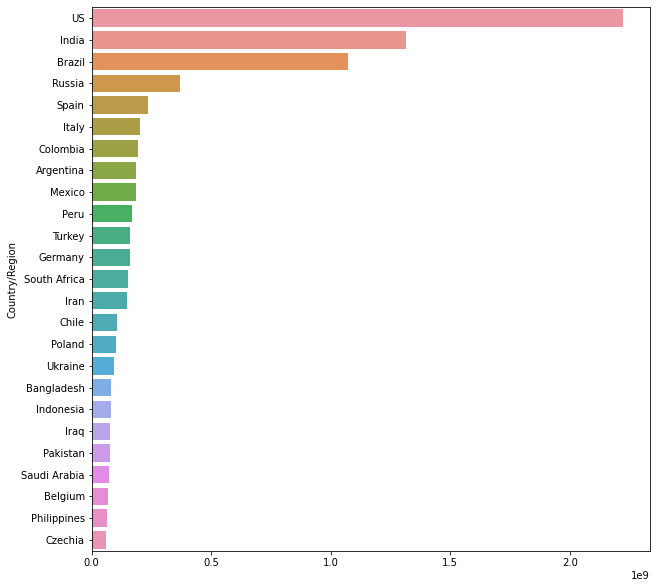

In [22]:

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(y=worst_countries.index[:25], x=worst_countries.values[:25])

In [23]:
# This method is imp because we have data in accumulative format
def daily_values(data):
    d = [] 
    d.append(data[0])
    for i in range(1,len(data)):
        d.append(data[i]-data[i-1]) # get unique date for the day, since it is accumulative
    return d 

def weekly_average(data):
    weekly_average = []
    for i in range(len(data)):
        if i + 7 < len(data):
            weekly_average.append(np.mean(data[i:i+7]))
        else:
            weekly_average.append(np.mean(data[i:len(data)]))
    return weekly_average


# mortality rate
mortality_rate = np.array(daily_values(total_deaths))/np.array(daily_values(total_cases))

#recovery rate
recovery_rate = np.array(daily_values(total_recoveries))/np.array(daily_values(total_cases))

In [24]:
#days array
days = np.array(range(len(dates))).reshape(-1, 1)

# confirmed cases
global_daily_values = daily_values(total_cases)
global_daily_increase_avg = weekly_average(global_daily_values)

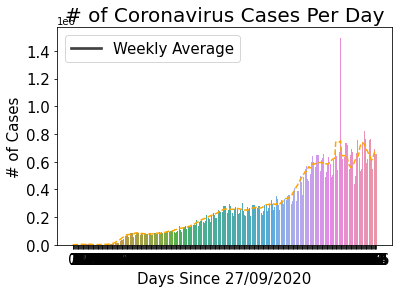

In [25]:
sns.barplot(x = list(range(len(global_daily_values))),y = global_daily_values)
plt.plot(days, global_daily_increase_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Per Day', size=20)
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.legend(['Weekly Average'], prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

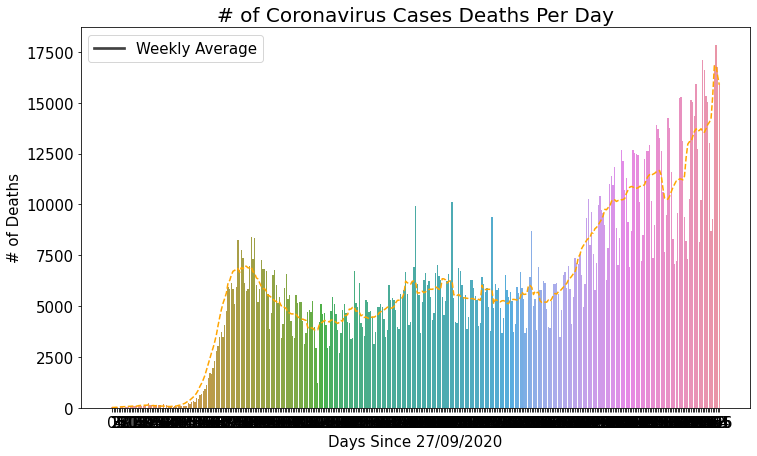

In [26]:
# Daily Deaths
global_daily_deaths = daily_values(total_deaths)
global_daily_death_avg = weekly_average(global_daily_deaths)

fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x = list(range(len(global_daily_deaths))),y=global_daily_deaths)
plt.plot(days, global_daily_death_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Deaths Per Day', size=20)
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Deaths', size=15)
plt.legend(['Weekly Average'], prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

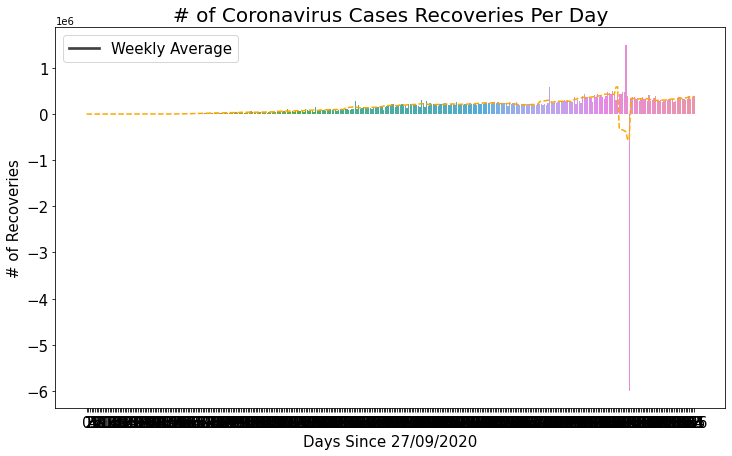

In [27]:

# Daily Recoveries
global_daily_recoveries = daily_values(total_recoveries)
global_daily_recoveries_avg = weekly_average(global_daily_recoveries)


fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x = list(range(len(global_daily_recoveries))),y=global_daily_recoveries)
plt.plot(days, global_daily_recoveries_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Recoveries Per Day', size=20)
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Recoveries', size=15)
plt.legend(['Weekly Average'], prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

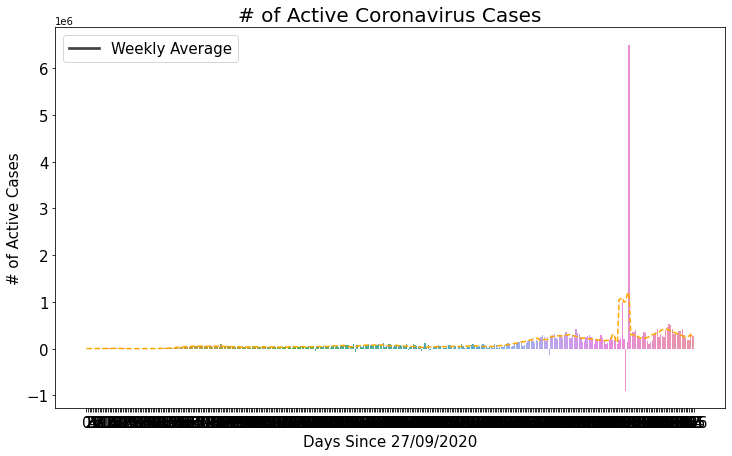

In [28]:

#Active Cases
global_daily_active = daily_values(total_active)
global_active_avg = weekly_average(global_daily_active)


fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x = list(range(len(global_daily_active))),y=global_daily_active)
plt.plot(days, global_active_avg, linestyle='dashed', color='orange')
plt.title('# of Active Coronavirus Cases', size=20)
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Active Cases', size=15)
plt.legend(['Weekly Average'], prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

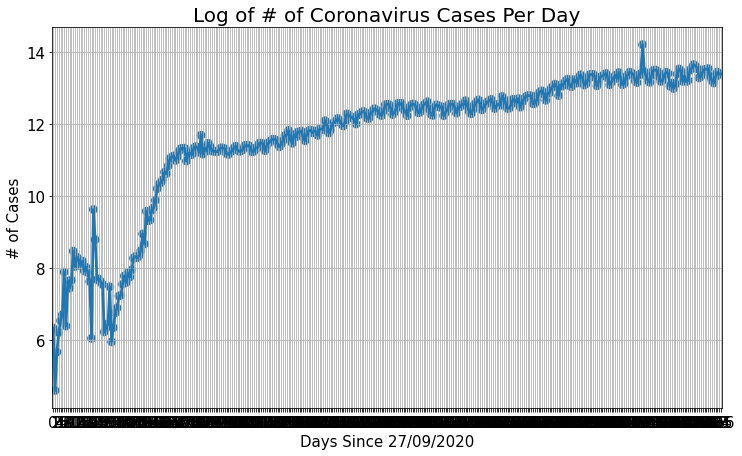

In [29]:
plt.figure(figsize=(12, 7))
sns.pointplot(x = days[:,0] , y = np.log(global_daily_values))
plt.title('Log of # of Coronavirus Cases Per Day', size=20)
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()

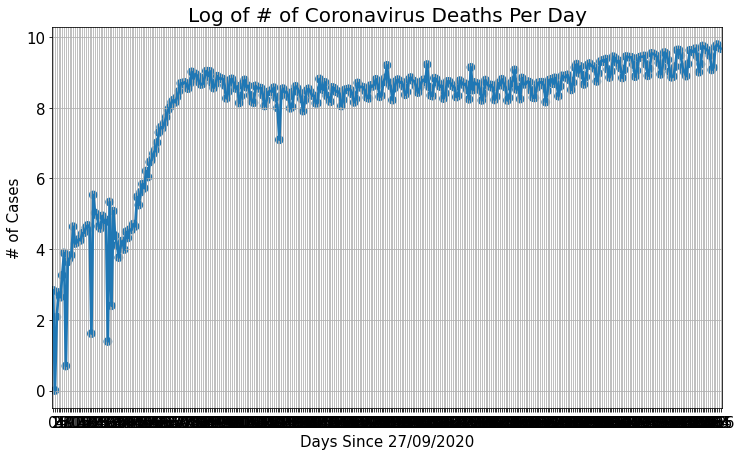

In [30]:
plt.figure(figsize=(12, 7))
sns.pointplot(x = days[:,0] , y = np.log(global_daily_deaths))
plt.title('Log of # of Coronavirus Deaths Per Day', size=20)
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


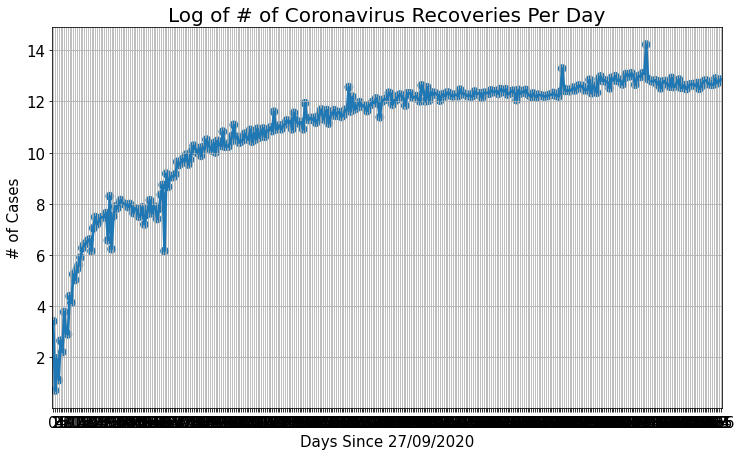

In [31]:
plt.figure(figsize=(12, 7))
sns.pointplot(x = days[:,0] , y = np.log(global_daily_recoveries))
plt.title('Log of # of Coronavirus Recoveries Per Day', size=20)
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()

**Let's look at the Recovery and mortality rate**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


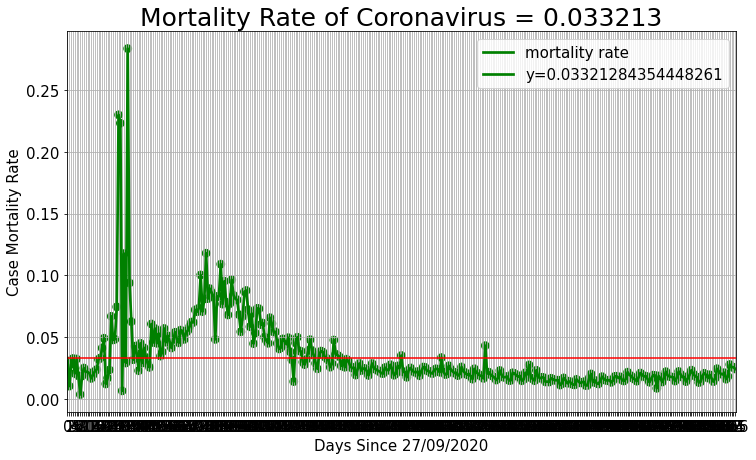

In [32]:
plt.figure(figsize=(12, 7))

sns.pointplot(days[:,0], mortality_rate, color='Green')
plt.axhline(y = np.mean(mortality_rate),linestyle='-', color='red')
plt.title('Mortality Rate of Coronavirus = {0:2f}'.format(np.mean(mortality_rate)), size=25)
plt.legend(['mortality rate', 'y='+str(np.mean(mortality_rate))], prop={'size': 15})
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('Case Mortality Rate', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


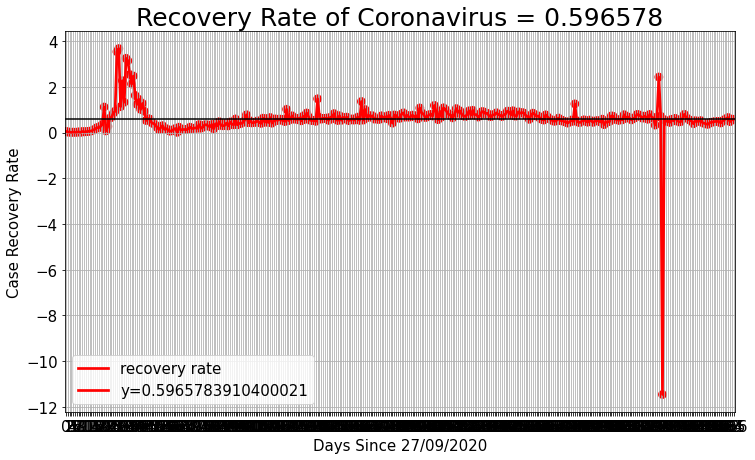

In [33]:
plt.figure(figsize=(12, 7))

sns.pointplot(days[:,0], recovery_rate, color='red')
plt.axhline(y = np.mean(recovery_rate),linestyle='-', color='black')
plt.title('Recovery Rate of Coronavirus = {0:2f}'.format(np.mean(recovery_rate)), size=25)
plt.legend(['recovery rate', 'y='+str(np.mean(recovery_rate))], prop={'size': 15})
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('Case Recovery Rate', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()

In [34]:

con_wise_confirm_cases = {}
con_wise_recovered_cases = {}
con_wise_death_cases = {}

for c in worst_countries.index:
    con_wise_confirm_cases[c] = confirmed_df[confirmed_df['Country/Region']==c].loc[:,dates].sum(axis = 0).values
    con_wise_death_cases[c] = deaths_df[deaths_df['Country/Region']==c].loc[:,dates].sum(axis = 0).values
    con_wise_recovered_cases[c] = recoveries_df[recoveries_df['Country/Region']==c].loc[:,dates].sum(axis = 0).values
    
# Let's look at confirmed cases in India
con_wise_confirm_cases['India']

array([       0,        0,        0,        0,        0,        0,
              0,        0,        1,        1,        1,        2,
              3,        3,        3,        3,        3,        3,
              3,        3,        3,        3,        3,        3,
              3,        3,        3,        3,        3,        3,
              3,        3,        3,        3,        3,        3,
              3,        3,        3,        3,        5,        5,
             28,       30,       31,       34,       39,       43,
             56,       62,       73,       82,      102,      113,
            119,      142,      156,      194,      244,      330,
            396,      499,      536,      657,      727,      887,
            987,     1024,     1251,     1397,     1998,     2543,
           2567,     3082,     3588,     4778,     5311,     5916,
           6725,     7598,     8446,     9205,    10453,    11487,
          12322,    13430,    14352,    15722,    17615,    18

In [36]:

# list of all the countries!!
con_wise_confirm_cases.keys()

dict_keys(['US', 'India', 'Brazil', 'Russia', 'Spain', 'Italy', 'Colombia', 'Argentina', 'Mexico', 'Peru', 'Turkey', 'Germany', 'South Africa', 'Iran', 'Chile', 'Poland', 'Ukraine', 'Bangladesh', 'Indonesia', 'Iraq', 'Pakistan', 'Saudi Arabia', 'Belgium', 'Philippines', 'Czechia', 'Romania', 'Israel', 'Morocco', 'Sweden', 'Switzerland', 'Portugal', 'Ecuador', 'Austria', 'Kazakhstan', 'Qatar', 'Panama', 'United Arab Emirates', 'Nepal', 'Bolivia', 'Dominican Republic', 'Belarus', 'Japan', 'Egypt', 'Kuwait', 'Serbia', 'Hungary', 'Oman', 'Jordan', 'Guatemala', 'Costa Rica'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


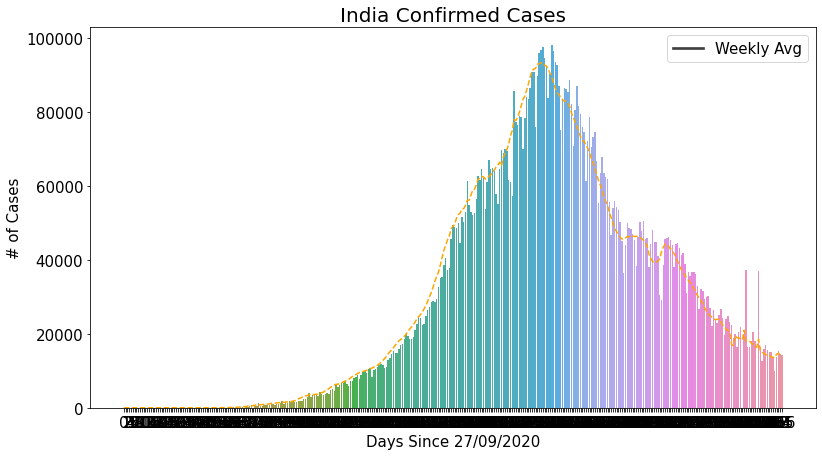

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


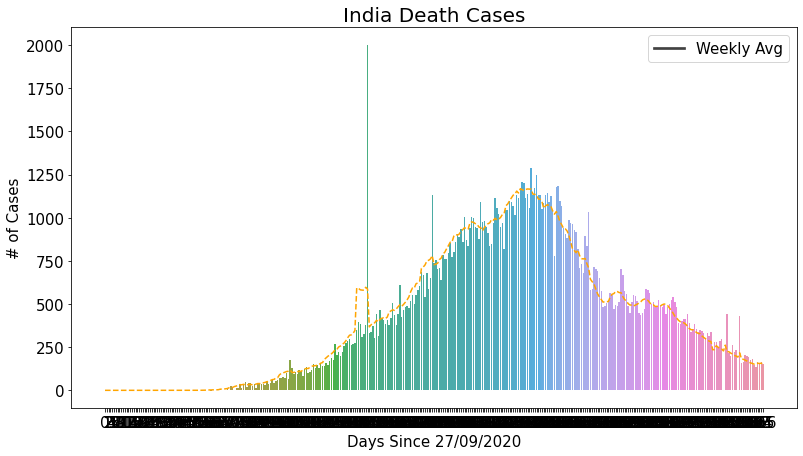

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


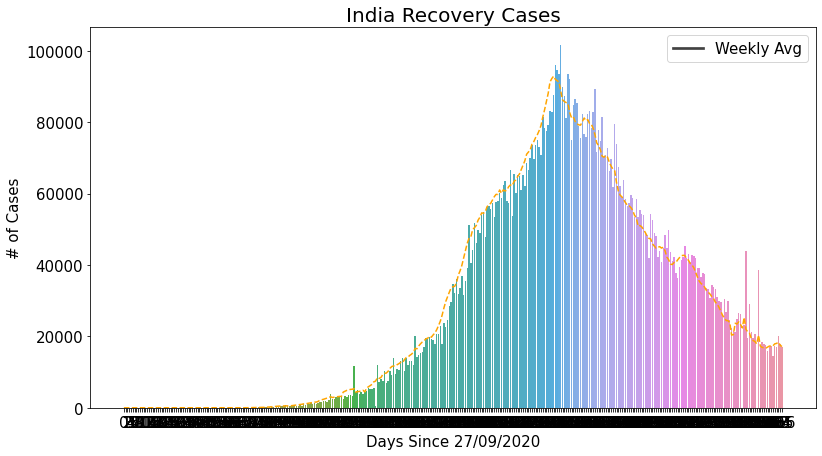

In [37]:
india_daily = daily_values(con_wise_confirm_cases['India'])
india_avg = weekly_average(india_daily)

india_daith_daily = daily_values(con_wise_death_cases['India'])
india_death_avg = weekly_average(india_daith_daily)

india_recovery_daily = daily_values(con_wise_recovered_cases['India'])
india_recovert_avg = weekly_average(india_recovery_daily)

plt.figure(figsize=(13, 7))
sns.barplot(days[:,0], india_daily)
plt.title('India Confirmed Cases', size=20)
plt.plot(days, india_avg, color='orange', linestyle='dashed')
plt.legend(['Weekly Avg'], prop={'size': 15})
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

plt.figure(figsize=(13, 7))
sns.barplot(days[:,0], india_daith_daily)
plt.title('India Death Cases', size=20)
plt.plot(days, india_death_avg, color='orange', linestyle='dashed')
plt.legend(['Weekly Avg'], prop={'size': 15})
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

plt.figure(figsize=(13, 7))
sns.barplot(days[:,0], india_recovery_daily)
plt.title('India Recovery Cases', size=20)
plt.plot(days, india_recovert_avg, color='orange', linestyle='dashed')
plt.legend(['Weekly Avg'], prop={'size': 15})
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


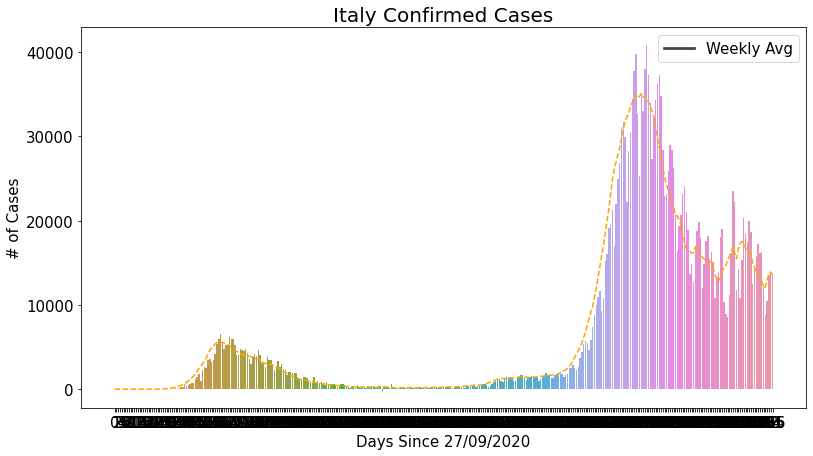

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


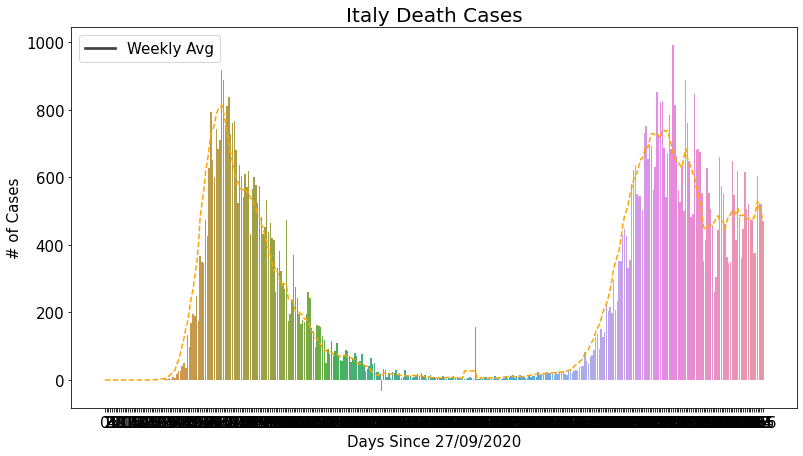

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


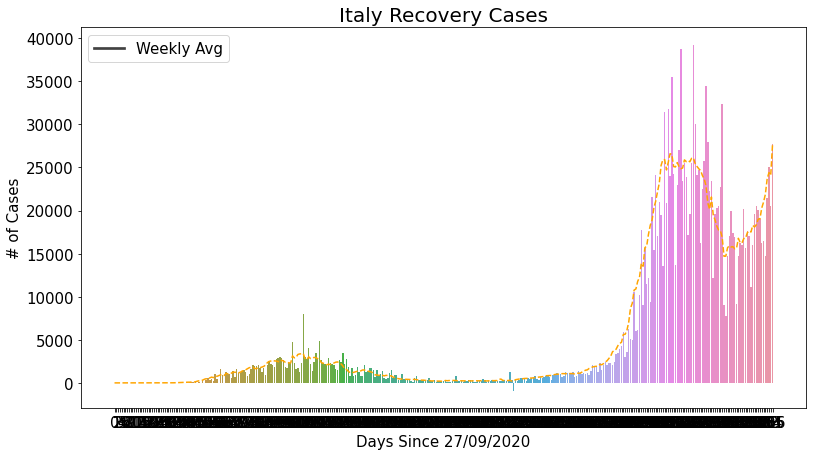

In [38]:
con_daily = daily_values(con_wise_confirm_cases['Italy'])
con_avg = weekly_average(con_daily)

con_daith_daily = daily_values(con_wise_death_cases['Italy'])
con_death_avg = weekly_average(con_daith_daily)

con_recovery_daily = daily_values(con_wise_recovered_cases['Italy'])
con_recovert_avg = weekly_average(con_recovery_daily)

plt.figure(figsize=(13, 7))
sns.barplot(days[:,0], con_daily)
plt.title('Italy Confirmed Cases', size=20)
plt.plot(days, con_avg, color='orange', linestyle='dashed')
plt.legend(['Weekly Avg'], prop={'size': 15})
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

plt.figure(figsize=(13, 7))
sns.barplot(days[:,0], con_daith_daily)
plt.title('Italy Death Cases', size=20)
plt.plot(days, con_death_avg, color='orange', linestyle='dashed')
plt.legend(['Weekly Avg'], prop={'size': 15})
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

plt.figure(figsize=(13, 7))
sns.barplot(days[:,0], con_recovery_daily)
plt.title('Italy Recovery Cases', size=20)
plt.plot(days, con_recovert_avg, color='orange', linestyle='dashed')
plt.legend(['Weekly Avg'], prop={'size': 15})
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


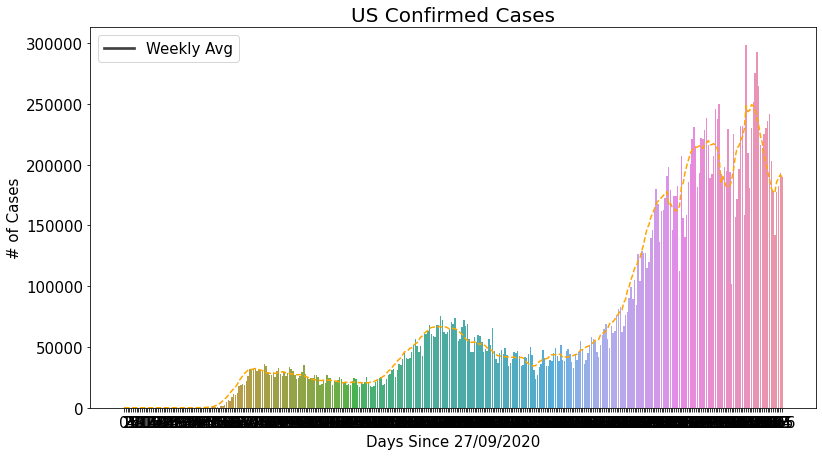

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


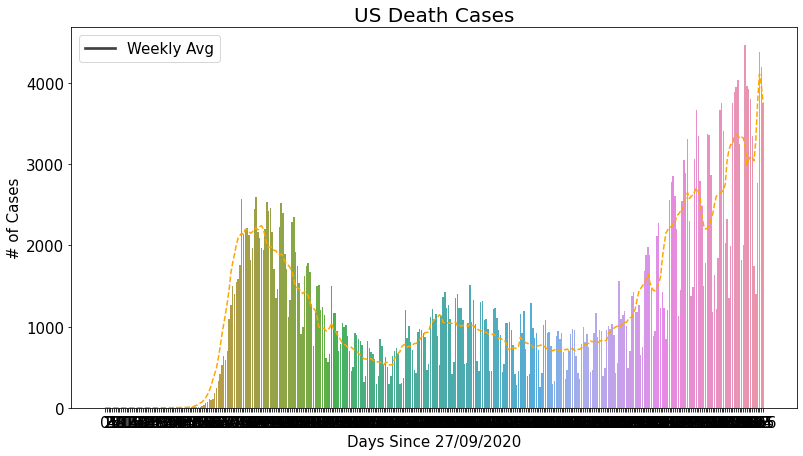

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


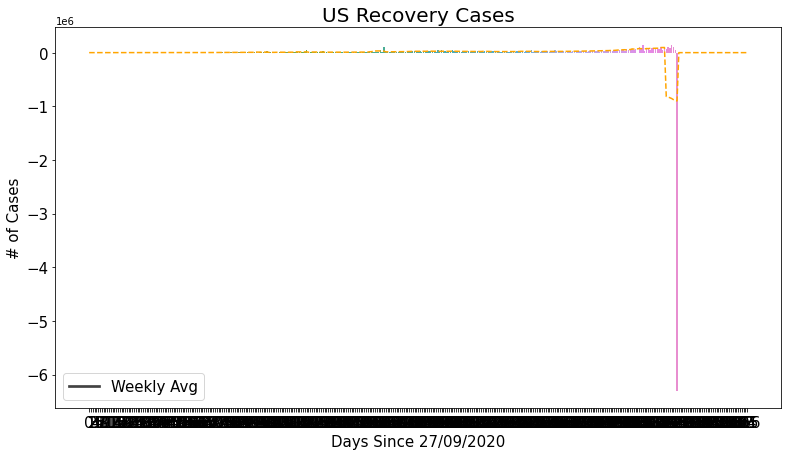

In [39]:
con_daily = daily_values(con_wise_confirm_cases['US'])
con_avg = weekly_average(con_daily)

con_daith_daily = daily_values(con_wise_death_cases['US'])
con_death_avg = weekly_average(con_daith_daily)

con_recovery_daily = daily_values(con_wise_recovered_cases['US'])
con_recovert_avg = weekly_average(con_recovery_daily)

plt.figure(figsize=(13, 7))
sns.barplot(days[:,0], con_daily)
plt.title('US Confirmed Cases', size=20)
plt.plot(days, con_avg, color='orange', linestyle='dashed')
plt.legend(['Weekly Avg'], prop={'size': 15})
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

plt.figure(figsize=(13, 7))
sns.barplot(days[:,0], con_daith_daily)
plt.title('US Death Cases', size=20)
plt.plot(days, con_death_avg, color='orange', linestyle='dashed')
plt.legend(['Weekly Avg'], prop={'size': 15})
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

plt.figure(figsize=(13, 7))
sns.barplot(days[:,0], con_recovery_daily)
plt.title('US Recovery Cases', size=20)
plt.plot(days, con_recovert_avg, color='orange', linestyle='dashed')
plt.legend(['Weekly Avg'], prop={'size': 15})
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

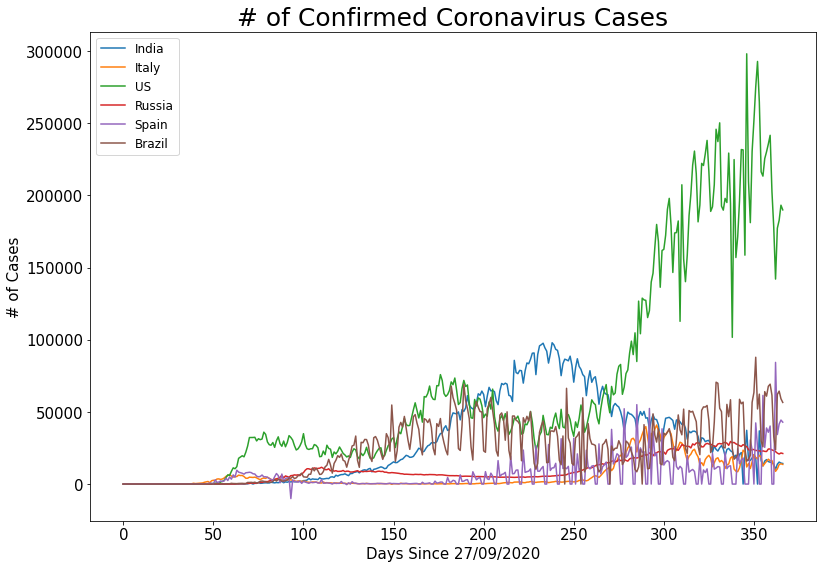

In [40]:
plt.figure(figsize=(13, 9))
sns.lineplot(days[:,0], daily_values(con_wise_confirm_cases['India']))
sns.lineplot(days[:,0], daily_values(con_wise_confirm_cases['Italy']))
sns.lineplot(days[:,0], daily_values(con_wise_confirm_cases['US']))
sns.lineplot(days[:,0], daily_values(con_wise_confirm_cases['Russia']))
sns.lineplot(days[:,0], daily_values(con_wise_confirm_cases['Spain']))
sns.lineplot(days[:,0], daily_values(con_wise_confirm_cases['Brazil']))

plt.title('# of Confirmed Coronavirus Cases', size=25)
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.legend(['India', 'Italy', 'US', 'Russia', 'Spain','Brazil'], prop={'size': 12})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

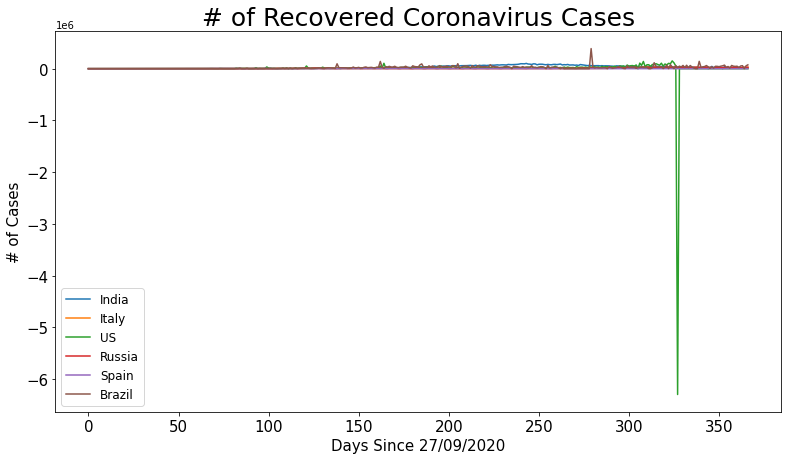

In [41]:
plt.figure(figsize=(13, 7))
sns.lineplot(days[:,0], daily_values(con_wise_recovered_cases['India']))
sns.lineplot(days[:,0], daily_values(con_wise_recovered_cases['Italy']))
sns.lineplot(days[:,0], daily_values(con_wise_recovered_cases['US']))
sns.lineplot(days[:,0], daily_values(con_wise_recovered_cases['Russia']))
sns.lineplot(days[:,0], daily_values(con_wise_recovered_cases['Spain']))
sns.lineplot(days[:,0], daily_values(con_wise_recovered_cases['Brazil']))

plt.title('# of Recovered Coronavirus Cases', size=25)
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.legend(['India', 'Italy', 'US', 'Russia', 'Spain','Brazil'], prop={'size': 12})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

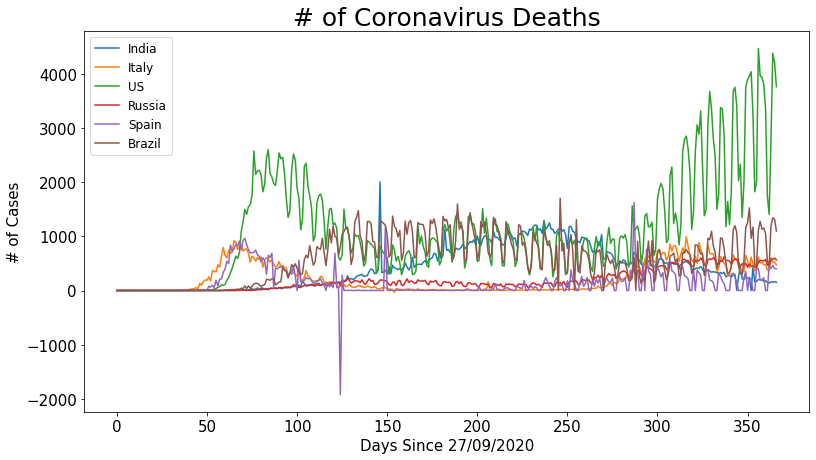

In [42]:
plt.figure(figsize=(13, 7))
sns.lineplot(days[:,0], daily_values(con_wise_death_cases['India']))
sns.lineplot(days[:,0], daily_values(con_wise_death_cases['Italy']))
sns.lineplot(days[:,0], daily_values(con_wise_death_cases['US']))
sns.lineplot(days[:,0], daily_values(con_wise_death_cases['Russia']))
sns.lineplot(days[:,0], daily_values(con_wise_death_cases['Spain']))
sns.lineplot(days[:,0], daily_values(con_wise_death_cases['Brazil']))

plt.title('# of Coronavirus Deaths', size=25)
plt.xlabel('Days Since 27/09/2020', size=15)
plt.ylabel('# of Cases', size=15)
plt.legend(['India', 'Italy', 'US', 'Russia', 'Spain','Brazil'], prop={'size': 12})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [43]:
latest_data_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/12-18-2020.csv')
latest_data_df.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-12-19 05:30:27,32.3182,-86.9023,315683,4296,183625.0,127762.0,1.0,6438.325293,1764750.0,NaN,1.360859,84000001.0,USA,35991.911380,NaN
1,Alaska,US,2020-12-19 05:30:27,61.3707,-152.4044,43352,183,7165.0,36004.0,2.0,5926.087937,1184922.0,NaN,0.422126,84000002.0,USA,161975.271514,NaN
2,American Samoa,US,2020-12-19 05:30:27,-14.2710,-170.1320,0,0,NaN,0.0,60.0,0.000000,2140.0,NaN,NaN,16.0,ASM,3846.084722,NaN
3,Arizona,US,2020-12-19 05:30:27,33.7298,-111.4312,442671,7819,65350.0,369502.0,4.0,6081.717424,2605792.0,NaN,1.766323,84000004.0,USA,35800.155439,NaN
4,Arkansas,US,2020-12-19 05:30:27,34.9697,-92.3731,197421,3139,171864.0,22418.0,5.0,6541.876146,1913448.0,NaN,1.590003,84000005.0,USA,63405.310617,NaN


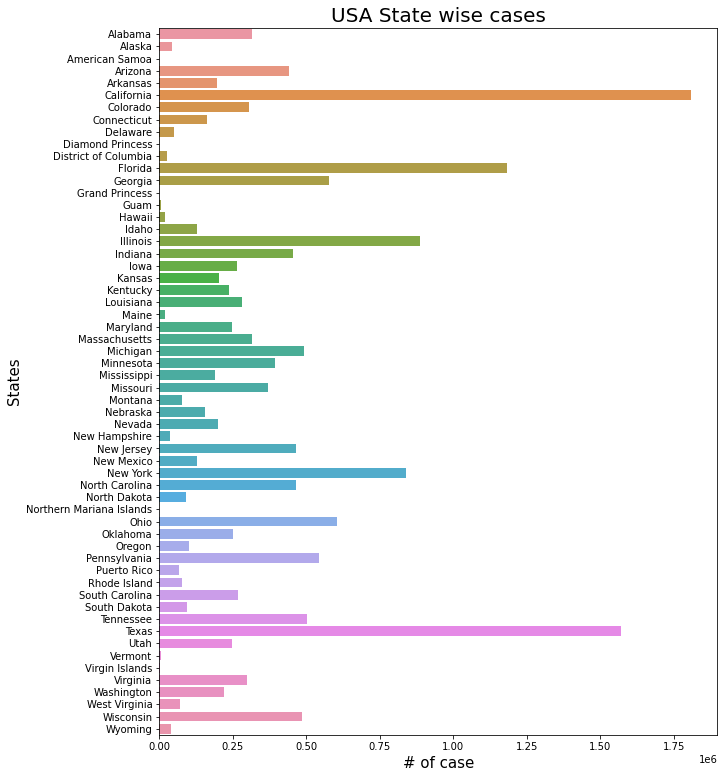

In [44]:
plt.figure(figsize=(10,13))
sns.barplot(x = latest_data_df['Confirmed'],y=latest_data_df['Province_State'])
plt.title('USA State wise cases', size=20)
plt.xlabel('# of case', size=15)
plt.ylabel('States', size=15)
plt.show()

**Worst hit state in US is California, followed by Texas, Florida, and New York**

In [45]:
x = latest_data_df['Confirmed'].sort_values(ascending=False)[:10]
y = []
for i in x.index:
    y.append(latest_data_df['Province_State'][i])
    
x = list(x)
temp = sum(latest_data_df['Confirmed'].sort_values(ascending=False)[10:])
x.append(temp)
y.append('Others')

Text(0.5, 1.0, '% of cases based on US states')

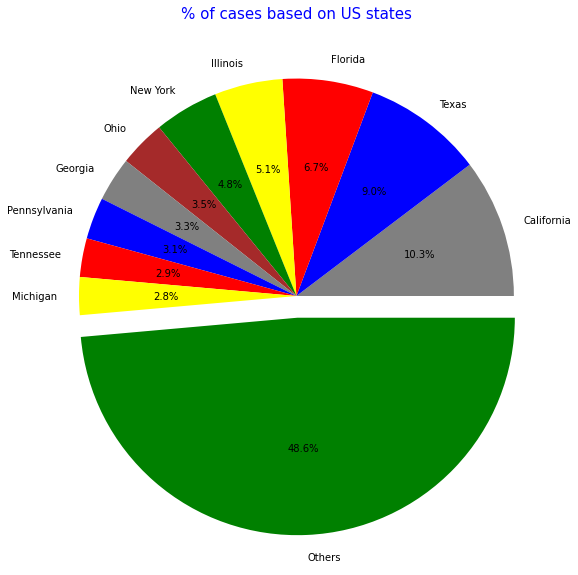

In [46]:
colors = ['grey','blue','red','yellow','green','brown']
explode = [0,0,0,0,0,0,0,0,0,0,0.1]

# visual
plt.figure(figsize = (10,10))
plt.pie(x, labels=y, explode = explode,colors=colors, autopct='%1.1f%%')
plt.title('% of cases based on US states',color = 'blue',fontsize = 15)